In [1]:
import torch
import torchvision
from torchvision import datasets,transforms,models
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import PIL
import os
import zipfile

In [2]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cat', 'dog']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

In [3]:
for class_name in class_names:
    source_dir = os.path.join('train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 10 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
            shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 12510/12510 [00:00<00:00, 25959.42it/s]


Validation folder is done

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [5]:
len(train_dataloader), len(train_dataset)

(3127, 25010)

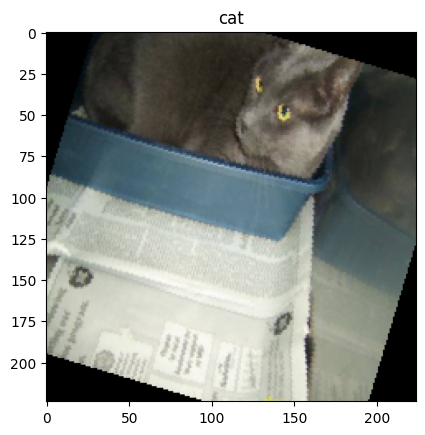

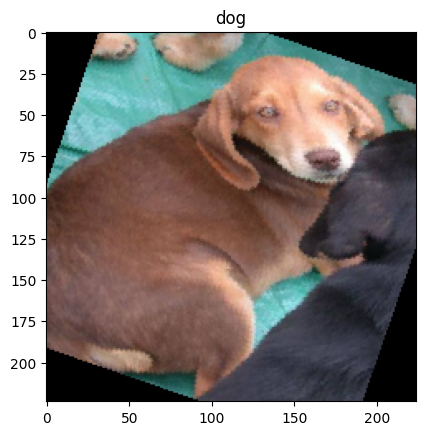

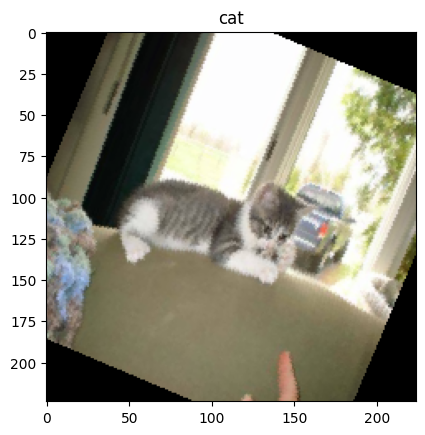

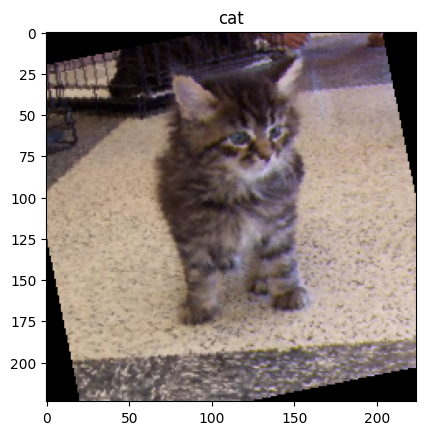

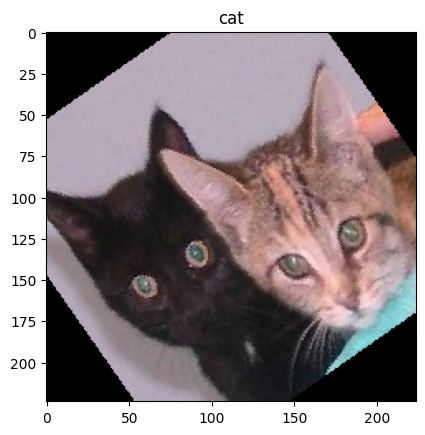

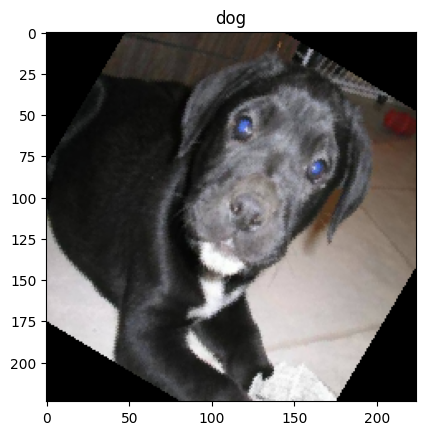

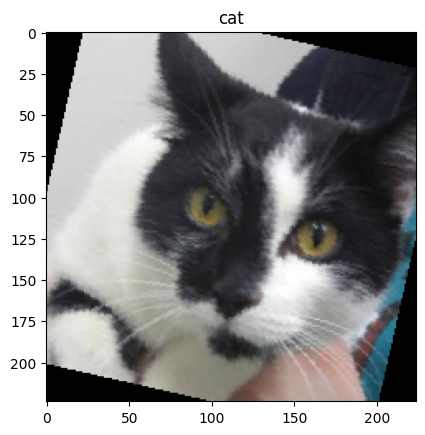

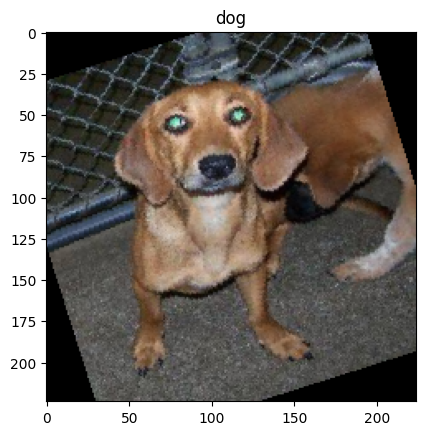

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [8]:
model = models.resnet50(progress=True,weights='DEFAULT')

# Disable grad for all conv layers
for param in model.parameters():
        param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
train_model(model, loss, optimizer, scheduler, num_epochs=1)#is better to use more epochs on trained model i used 10

Epoch 0/0:


100%|██████████| 3127/3127 [13:18<00:00,  3.91it/s]

train Loss: 0.0849 Acc: 0.9668



100%|██████████| 313/313 [01:46<00:00,  2.94it/s]

val Loss: 0.0396 Acc: 0.9884


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
torch.save(model,'models/model.zip')

In [12]:
model = torch.load('model.zip',map_location='cpu')

In [76]:
test_dir = 'test'
shutil.copytree(os.path.join('test1'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [40]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [41]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


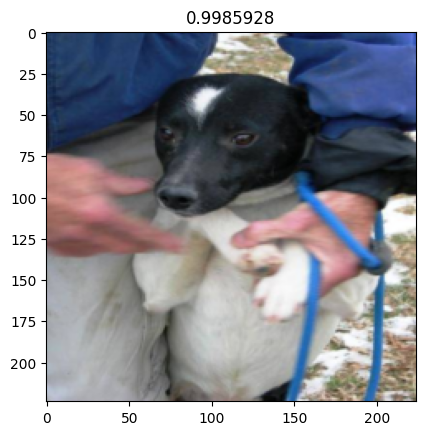

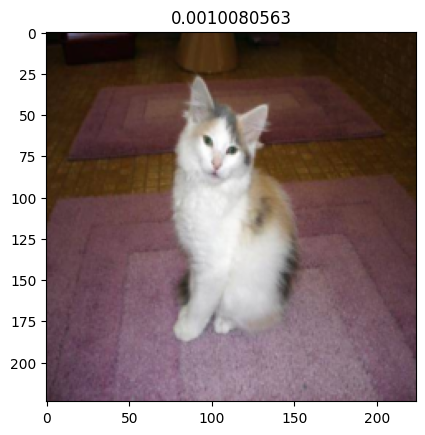

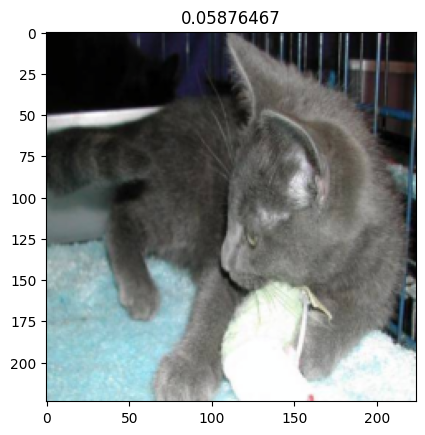

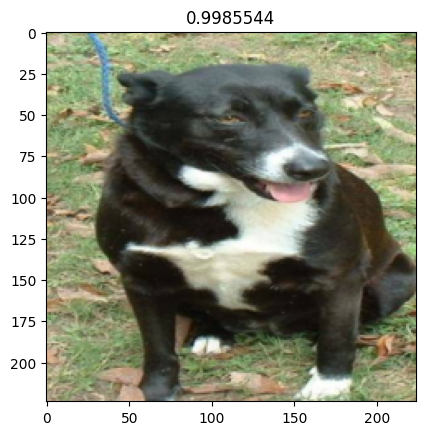

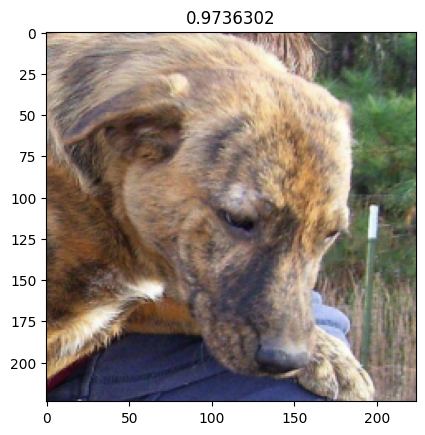

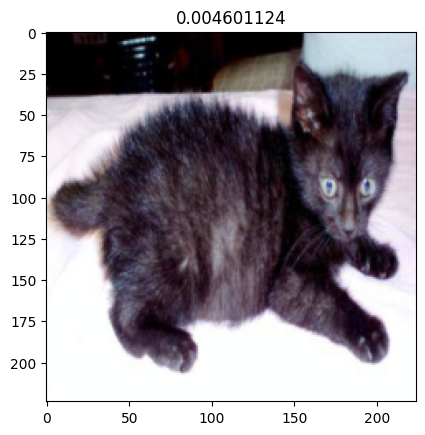

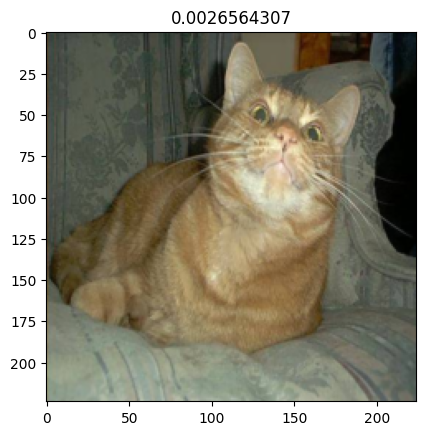

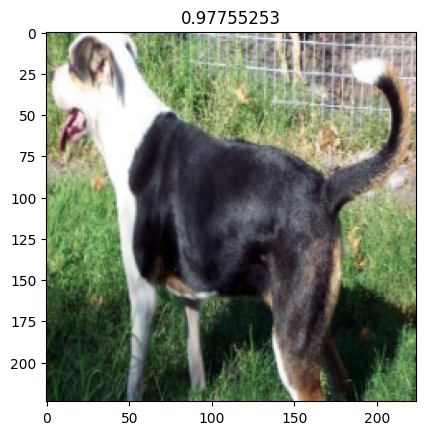

In [42]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [69]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [70]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'cat' if pred < 0.5 else 'dog')
submission_df['id'] = submission_df['id'].str.replace('test', '')
submission_df['id'] = submission_df['id'].str.replace('unknown', '')
submission_df['id'] = submission_df['id'].str.replace('//', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


In [71]:
submission_df['id'] = submission_df['id'].astype(dtype='Int64')
submission_df.head(n=6)

,id,label
0,1,dog
1,10,cat
2,100,cat
3,1000,dog
4,10000,dog
5,10001,cat


In [72]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      12500 non-null  Int64 
 1   label   12500 non-null  object
dtypes: Int64(1), object(1)
memory usage: 207.6+ KB


In [73]:
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
1,dog
10,cat
100,cat
1000,dog
10000,dog
10001,cat


In [74]:
submission_df.sort_values(by=['id'])

,label
id,
1,dog
2,dog
3,dog
4,dog
5,cat
...,...
12496,cat
12497,cat
12498,dog


In [75]:
submission_df.to_csv('submission.csv')